In [1]:
%load_ext autoreload

In [2]:
import numpy as np
from functools import partial
from iris_plant_visualizer import IrisPlantVisualizer
import ipywidgets as widgets
from IPython.display import display
from scipy.linalg import block_diag
from time import perf_counter

In [3]:
#pydrake imports
from pydrake.common import FindResourceOrThrow
from pydrake.multibody.parsing import LoadModelDirectives, Parser, ProcessModelDirectives
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.framework import DiagramBuilder
from pydrake.geometry import Role, GeometrySet, CollisionFilterDeclaration
from pydrake.all import RigidTransform, RollPitchYaw, RevoluteJoint
from pydrake.all import RotationMatrix, Rgba
import time
import pydrake.multibody.rational as rational_forward_kinematics
from pydrake.all import RationalForwardKinematics
from pydrake.all import GeometrySet, CollisionFilterDeclaration, CollisionFilterManager
from pydrake.geometry.optimization import IrisOptions, IrisInRationalConfigurationSpace, HPolyhedron, Hyperellipsoid
from pydrake.solvers import MosekSolver, CommonSolverOption, SolverOptions

In [4]:
from pydrake.geometry.optimization_dev import (CspaceFreePolytope, 
                                               SeparatingPlaneOrder)

In [5]:
# import logging
# drake_log = logging.getLogger("drake")
# drake_log.setLevel("DEBUG")

# Build and set up the visualization the plant and the visualization of the C-space obstacle

We first set up a simple 2-DOF system and visualize both the plant and the configuration constraint.Click on the two links at the bottom to view the plant and the configuration space.

Note that running this cell multiple times will establish multiple meshcat instances which can fill up your memory. It is a good idea to call "pkill -f meshcat" from the command line before re-running this cell


In [6]:
#construct our robot
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
collision_filter_manager = scene_graph.collision_filter_manager()
inspector = scene_graph.model_inspector()

parser = Parser(plant)
directives_file = FindResourceOrThrow("drake/C_Iris_Examples/directives/trans2dof_directives.yaml") 
directives = LoadModelDirectives(directives_file)
models = ProcessModelDirectives(directives, plant, parser)

# Exclude the base of the iiwa from collision with the box
iiwa_base_name = "iiwa_twoDOF_link_0"
box_base_name = "box1"
def GetCollisionGeometriesByName(name):
    body = plant.GetBodyByName(name)
    return plant.GetCollisionGeometriesForBody(body)
iiwa_base_geom_set = GeometrySet()
iiwa_base_geom_set.Add(GetCollisionGeometriesByName(iiwa_base_name))
box_base_geom_set = GeometrySet()
box_base_geom_set.Add(GetCollisionGeometriesByName(box_base_name))

collision_filter_manager.Apply(
    CollisionFilterDeclaration().ExcludeBetween(iiwa_base_geom_set, box_base_geom_set)
)
plant.Finalize()

        
# construct the RationalForwardKinematics of this plant. This object handles the
# computations for the forward kinematics in the tangent-configuration space
Ratfk = RationalForwardKinematics(plant)

# the point about which we will take the stereographic projections
q_star = np.zeros(plant.num_positions())

do_viz = True

# The object we will use to perform our certification.
cspace_free_polytope = CspaceFreePolytope(plant, scene_graph, SeparatingPlaneOrder.kAffine, q_star)

# This line builds the visualization. Change the viz_role to Role.kIllustration if you
# want to see the plant with its illustrated geometry or to Role.kProximity if you want
# to see the plant with the collision geometries.
visualizer = IrisPlantVisualizer(plant, builder, scene_graph, cspace_free_polytope, viz_role=Role.kIllustration)
visualizer.visualize_collision_constraint(factor = 1.5, num_points = 100)
visualizer.meshcat_cspace.Set2dRenderMode(RigidTransform(RotationMatrix.MakeZRotation(0), np.array([0,0,1])))
visualizer.meshcat_task_space.Set2dRenderMode(RigidTransform(RotationMatrix.MakeZRotation(0), np.array([1,0,0])))

INFO:drake:Meshcat listening for connections at http://localhost:7002
INFO:drake:Meshcat listening for connections at http://localhost:7003


## Set up the sliders so we can move the plant around manually

You can use the sliders below to move the two degrees of freedom of the plant around. A green dot will appear in the TC-space visualization describing the current TC-space configuration.

In [7]:
sliders = []
for i in range(plant.num_positions()):
    q_low = plant.GetPositionLowerLimits()[i]
    q_high = plant.GetPositionUpperLimits()[i]
    sliders.append(widgets.FloatSlider(min=q_low, max=q_high, value=0, description=f"q{i}"))

q = np.zeros(plant.num_positions())
def handle_slider_change(change, idx):
    q[idx] = change['new']
    visualizer.show_res_q(q)
    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

for slider in sliders:
    display(slider)


FloatSlider(value=0.0, description='q0', max=0.96706, min=-0.96706)

FloatSlider(value=0.0, description='q1', max=2.0944, min=-2.0944)

# Generate and Certify Regions

Around some nominal seed postures, we will grow certified regions by seeding our alternation algorithm using a small initial polytope.

In [8]:
# Some seedpoints
seed_points_q = np.array([
    [0,0]
#     [-0.07, 1.81],
#                           [0.03, -1.79],
#                           [0.43, -1.69]
                         ])
seed_points = np.array([Ratfk.ComputeSValue(seed_points_q[idx], np.zeros((2,)))\
                        for idx in range(seed_points_q.shape[0])])
if do_viz:
    visualizer.plot_cspace_points(seed_points, "/iris_seed_points")
    


default_scale = 1e-2
L1_ball = HPolyhedron.MakeL1Ball(2)
Linf_ball = HPolyhedron.MakeBox(-np.ones(2), np.ones(2))

template_C = np.vstack([L1_ball.A(), Linf_ball.A()])
template_d = np.hstack([default_scale*L1_ball.b(), default_scale/np.sqrt(2)*Linf_ball.b()])


def make_default_polytope_at_point(seed_point):
    return HPolyhedron(template_C, template_d + template_C @ seed_point)


# colors to plot the region. Chosen for color-blind compatibility
default_alpha = 0.2
colors_dict = {
    3: Rgba(0.565, 0.565, 0.565, default_alpha),
    1: Rgba(0.118, 0.533, 0.898, default_alpha), # bluish
    2: Rgba(1,     0.757, 0.027, default_alpha), # gold
    0: Rgba(0,     0.549, 0.024, default_alpha), # green    
}

iris_regions = []
iris_ellipses = []

iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.configuration_space_margin = 1e-3
iris_options.relative_termination_threshold = 0.001

context_for_iris = visualizer.task_space_diagram_context
for i, s in enumerate(seed_points):
    q = Ratfk.ComputeQValue(s, q_star)
    plant.SetPositions(plant.GetMyMutableContextFromRoot(context_for_iris), q)
    r = IrisInRationalConfigurationSpace(plant, 
                                         plant.GetMyContextFromRoot(context_for_iris),
                                         q_star, iris_options)
    iris_regions.append((r, colors_dict[i]))
    iris_ellipses.append(r.MaximumVolumeInscribedEllipsoid())
    



def scale_polytope_about_point(hpoly, s, scale):
    if not hpoly.PointInSet(s):
        raise ValueError(f"The point s must be in the HPolyhedron")
    b_scaled = scale * hpoly.b() + (1 - scale) * hpoly.A() @ s
    return HPolyhedron(hpoly.A(), b_scaled)
    
r = iris_regions[0][0]
r_scaled = scale_polytope_about_point(r, seed_points[0], 0.05)
    
# initial_regions = [(make_default_polytope_at_point(s), colors_dict[i]) for i, s in enumerate(seed_points)]
initial_regions = [(r_scaled, colors_dict[0])]

visualizer.add_group_of_regions_to_visualization(initial_regions, "initial_regions",
                            wireframe = False,
                           opacity = default_alpha)
visualizer.show_res_q(q_star)

## First we set up some options for our different certification modes

In [9]:
# set up the certifier and the options for different search techniques
solver_options = SolverOptions()
# set this to 1 if you would like to see the solver output in terminal.
solver_options.SetOption(CommonSolverOption.kPrintToConsole, 0)

# The options for when we search for new planes and positivity certificates given the polytopes
find_separation_certificate_given_polytope_options = CspaceFreePolytope.FindSeparationCertificateGivenPolytopeOptions()
find_separation_certificate_given_polytope_options.num_threads = -1
find_separation_certificate_given_polytope_options.verbose = False
find_separation_certificate_given_polytope_options.solver_options = solver_options
find_separation_certificate_given_polytope_options.ignore_redundant_C = True

# The options for when we search for a new polytope given positivity certificates.
find_polytope_given_lagrangian_option = CspaceFreePolytope.FindPolytopeGivenLagrangianOptions()
find_polytope_given_lagrangian_option.solver_options = solver_options
find_polytope_given_lagrangian_option.ellipsoid_margin_cost = CspaceFreePolytope.EllipsoidMarginCost.kGeometricMean
find_polytope_given_lagrangian_option.search_s_bounds_lagrangians = True

bilinear_alternation_options = CspaceFreePolytope.BilinearAlternationOptions()
bilinear_alternation_options.max_iter = 250
bilinear_alternation_options.convergence_tol = 1e-4
bilinear_alternation_options.find_polytope_options = find_polytope_given_lagrangian_option
bilinear_alternation_options.find_lagrangian_options = find_separation_certificate_given_polytope_options

binary_search_options = CspaceFreePolytope.BinarySearchOptions()
binary_search_options.find_lagrangian_options = find_separation_certificate_given_polytope_options
binary_search_options.scale_min = 1
binary_search_options.scale_max = 50
binary_search_options.max_iter = 50

In [10]:
region = initial_regions[0][0]
progs = cspace_free_polytope.ConstructPlaneSearchProgramsForPairs(region.A(), region.b(), find_separation_certificate_given_polytope_options)

In [11]:
len(cspace_free_polytope.separating_planes())

42

In [12]:
len(progs)

42

In [13]:
cert_prog = progs[0].prog()

In [14]:
cert_prog.num_vars()

236

In [25]:
print(len(cert_prog.GetAllConstraints()))

192


In [24]:
print(len(cert_prog.linear_equality_constraints()))

80


In [18]:
print(cert_prog)

Decision variables: plane_var0  plane_var1  plane_var2  plane_var3  plane_var4  plane_var5  plane_var6  plane_var7  plane_var8  plane_var9 plane_var10 plane_var11     Gram(0)     Gram(1)     Gram(2)     Gram(3)     Gram(4)     Gram(5)     Gram(6)     Gram(7)     Gram(8)     Gram(9)    Gram(10)    Gram(11)    Gram(12)    Gram(13)    Gram(14)    Gram(15)    Gram(16)    Gram(17)    Gram(18)    Gram(19)    Gram(20)    Gram(21)    Gram(22)    Gram(23)    Gram(24)    Gram(25)    Gram(26)    Gram(27)    Gram(28)    Gram(29)    Gram(30)    Gram(31)    Gram(32)    Gram(33)    Gram(34)    Gram(35)    Gram(36)    Gram(37)    Gram(38)    Gram(39)    Gram(40)    Gram(41)    Gram(42)    Gram(43)    Gram(44)    Gram(45)    Gram(46)    Gram(47)    Gram(48)    Gram(49)    Gram(50)    Gram(51)    Gram(52)    Gram(53)    Gram(54)    Gram(55)    Gram(56)    Gram(57)    Gram(58)    Gram(59)    Gram(60)    Gram(61)    Gram(62)    Gram(63)    Gram(64)    Gram(65)    Gram(66)    Gram(67)    Gram(68)    Gram(6

In [21]:
print(len(cert_prog.positive_semidefinite_constraints()) + 
          len(cert_prog.rotated_lorentz_cone_constraints()) + 
              len(cert_prog.bounding_box_constraints()))

112


# Growing regions with bilinear alternations search

### As the initial regions are fairly small, they won't contain collisions and so can be directly fed into the bilinear alternation algorithm.

In [16]:
# We grow certified regions around each seedpoint using bilinear alternation.
bilinear_alternation_results_by_seed_point = dict.fromkeys([tuple(s) for s in seed_points])
times_per_region = []
for i, (s, (initial_region, color)) in enumerate(zip(seed_points, initial_regions)):
    print(f"starting seedpoint {i+1}/{len(initial_regions)}")
    time.sleep(0.1) # make the above print before the Drake log.
    bilinear_alternation_options.find_polytope_options.s_inner_pts = s
    t_start = time.perf_counter()
    result = cspace_free_polytope.SearchWithBilinearAlternation(set(), initial_region.A(),
                                                                initial_region.b(),
                                                                bilinear_alternation_options)
    t_end = time.perf_counter()
    times_per_region.append(t_end - t_start)
    bilinear_alternation_results_by_seed_point[tuple(s)] = [(cert.certified_polytope,
                                                             cert, color) for cert in result]



INFO:drake:det(Q) at the beginning is 0.0015502304794460765


starting seedpoint 1/1


INFO:drake:Iteration 0: det(Q)=0.006574658106270407
INFO:drake:Iteration 1: det(Q)=0.015544331432066962
INFO:drake:Iteration 2: det(Q)=0.02828002960812167
INFO:drake:Iteration 3: det(Q)=0.044000140454928054
INFO:drake:Iteration 4: det(Q)=0.06261139089802552
INFO:drake:Iteration 5: det(Q)=0.08310739554537176
INFO:drake:Iteration 6: det(Q)=0.10433449762778756
INFO:drake:Iteration 7: det(Q)=0.127383884581499
INFO:drake:Iteration 8: det(Q)=0.15102820968407776
INFO:drake:Iteration 9: det(Q)=0.17480986934013468
INFO:drake:Iteration 10: det(Q)=0.19816587048150658
INFO:drake:Iteration 11: det(Q)=0.22071503946328544
INFO:drake:Iteration 12: det(Q)=0.24219175623763825
INFO:drake:Iteration 13: det(Q)=0.2626030165727977
INFO:drake:Iteration 14: det(Q)=0.2821703154765489
INFO:drake:Iteration 15: det(Q)=0.3013858798128247
INFO:drake:Iteration 16: det(Q)=0.3208670228809974
INFO:drake:Iteration 17: det(Q)=0.34109060821187714
INFO:drake:Iteration 18: det(Q)=0.36180422403301327
INFO:drake:Iteration 19: 

In [17]:
for i in range(seed_points.shape[0]):
    print(f"Time to generate region {i} ={times_per_region[i]}")
print(f"Total time = {sum(times_per_region)}")

Time to generate region 0 =269.4633904310176
Total time = 269.4633904310176


In [18]:
bil_alt_search_result = [cert for (_, cert, _) in bilinear_alternation_results_by_seed_point[tuple(seed_points[0])]]

In [19]:
bil_alt_search_result

In [20]:
import matplotlib.pyplot as plt
data = [(c.num_iter, c.certified_polytope.MaximumVolumeInscribedEllipsoid().Volume()) 
        for c in bil_alt_search_result]


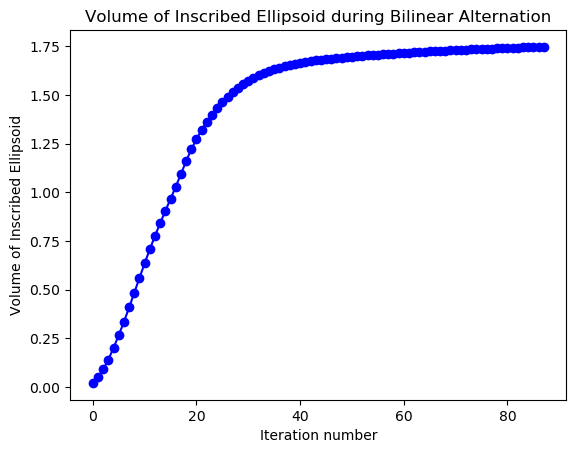

In [21]:
x, y = map(list, zip(*data))
plt.plot(x, y, 'bo-')
plt.xlabel("Iteration number")
plt.ylabel("Volume of Inscribed Ellipsoid")
plt.title("Volume of Inscribed Ellipsoid during Bilinear Alternation")
plt.savefig("pen_rail_vol.svg")
plt.show()

In [22]:
print(data)

[(0, 0.02107427569281062), (1, 0.04982548457498877), (2, 0.09064823309884389), (3, 0.1410371574432415), (4, 0.2006932819878337), (5, 0.2663907594167137), (6, 0.33443168172986343), (7, 0.4083137189949672), (8, 0.48410275893104543), (9, 0.5603320082582989), (10, 0.6351968604192709), (11, 0.7074755091466574), (12, 0.7763165413286138), (13, 0.8417423810586878), (14, 0.9044630039406597), (15, 0.966056183976805), (16, 1.028500644691531), (17, 1.0933249147708475), (18, 1.1597199186408227), (19, 1.2199392258134276), (20, 1.2731136924891662), (21, 1.3202329198264617), (22, 1.3613107229379708), (23, 1.3977865039854669), (24, 1.4312701570470698), (25, 1.4611990495497071), (26, 1.4888723321194406), (27, 1.5136322552735404), (28, 1.5353083876475688), (29, 1.5547418520209184), (30, 1.5717983405854514), (31, 1.586745620223682), (32, 1.6005093123371334), (33, 1.612485985965155), (34, 1.6229170109337532), (35, 1.6322708993041293), (36, 1.6404593760738704), (37, 1.6476816543427166), (38, 1.6540606582682

In [ ]:
# # visualize the regions and corresponding certificates
# for i, result in enumerate(bilinear_alternation_results_by_seed_point.values()):
#     group_name = f"/bil_alt_seed_point_{i}"
#     visualizer.add_group_of_regions_and_certs_to_visualization(result, group_name, 
#                                                                wireframe = False, 
#                                                                random_color_opacity = 0.2)

In [ ]:
all_r0 = list(bilinear_alternation_results_by_seed_point.values())[0]
regions = [all_r0[0]]
last_vol = regions[0][0].MaximumVolumeInscribedEllipsoid().Volume()
for i, (region, cert, color) in enumerate(all_r0):
    cur_vol = region.MaximumVolumeInscribedEllipsoid().Volume()
    delta = (cur_vol - last_vol)/last_vol
    if (cur_vol - last_vol)/last_vol > 0.2:
        last_vol = cur_vol
        regions.append((region, cert, None))
        
print(f"Kept {len(regions)}/{len(all_r0)}")

visualizer.add_group_of_regions_and_certs_to_visualization(regions, "partial_bil_alt",
                                                          wireframe = False, 
                                                           random_color_opacity = 0.0)

# Growing regions with binary search

### While the bilinear alternation scheme has the flexibility to search for fairly flexible polytopes, it can be relatively slow. We can search for larger regions faster by uniformly growing our polytopes using binary search

In [ ]:
# We grow certified regions around each seedpoint using binary search.
binary_search_results_by_seed_point = dict.fromkeys([tuple(s) for s in seed_points])
for i, (s, (initial_region, color)) in enumerate(zip(seed_points, initial_regions)):
    print(f"starting seedpoint {i+1}/{len(initial_regions)}")
    time.sleep(0.2)
    cert = cspace_free_polytope.BinarySearch(set(),initial_region.A(),
                                               initial_region.b(),
                                                 s,binary_search_options)
    binary_search_results_by_seed_point[tuple(s)] = [(cert.certified_polytope, cert, color)]
                                                     


In [ ]:
# visualize the regions and corresponding certificates
for i, result in enumerate(binary_search_results_by_seed_point.values()):
    group_name = f"/bin_search_seed_point_{i}"
    visualizer.add_group_of_regions_and_certs_to_visualization(result, group_name, 
                                                               wireframe = False, opacity = 0.2)

## Combining Binary Search and Bilinear Alternation
### Of course, we can get the best of both worlds by combining the two methods

In [ ]:
# we use this to back off a bit from the binary search results for numerical reasons
def scale_polytope_about_point(hpoly, s, scale):
    if not hpoly.PointInSet(s):
        raise ValueError(f"The point s must be in the HPolyhedron")
    b_scaled = scale * hpoly.b() + (1 - scale) * hpoly.A() @ s
    return HPolyhedron(hpoly.A(), b_scaled)
    

In [ ]:
# Now we grow certified regions around each seedpoint using bilinear alternation 
# starting from the binary certified regions.

# There is currently a bug in Mosek that kills the kernel if you this cell.

binary_and_bilinear_certified_regions = {k: [(r, cert, color)] for k,v in binary_search_results_by_seed_point.items() 
                                   for (r, cert, color) in v}

for i, (s, region_list) in enumerate(binary_and_bilinear_certified_regions.items()):
    bin_search_region, cert0, color = region_list[0]
    print(f"starting seedpoint {i+1}/{len(initial_regions)}")
    time.sleep(0.2)
    cur_s = np.array(s)
    bilinear_alternation_options.find_polytope_options.s_inner_pts = cur_s
    
    # We back off a little bit from the binary search solution so that we don't encounter numerical issues.
    initial_region = scale_polytope_about_point(bin_search_region, cur_s, 0.98)
    certificates = cspace_free_polytope.SearchWithBilinearAlternation(set(),
                                                                      initial_region.A(),
                                                                      initial_region.b(), 
                                                                      bilinear_alternation_options)
    
    binary_and_bilinear_certified_regions[s] += [(result.certified_polytope, result, color) for result in certificates]

In [ ]:
# visualize the regions and corresponding certificates
# for i, result in enumerate(binary_and_bilinear_certified_regions.values()):
#     group_name = f"/bin_then_bil_search_seed_point_{i}"
#     visualizer.add_group_of_regions_and_certs_to_visualization(result, group_name, 
#                                                                wireframe = False, opacity = 0.2)

In [ ]:
all_r0 = list(binary_and_bilinear_certified_regions.values())[0]
regions = [all_r0[0]]
last_vol = regions[0][0].MaximumVolumeInscribedEllipsoid().Volume()
for i, (region, cert, color) in enumerate(all_r0):
    cur_vol = region.MaximumVolumeInscribedEllipsoid().Volume()
    delta = (cur_vol - last_vol)/last_vol
    if (cur_vol - last_vol)/last_vol > 0.0:
        last_vol = cur_vol
        regions.append((region, cert, None))
        
print(f"Kept {len(regions)}/{len(all_r0)}")

visualizer.add_group_of_regions_and_certs_to_visualization(regions, "partial_bin_and_bil",
                                                          wireframe = False, 
                                                           random_color_opacity = 0.0)

## Seeding and Certifying with a Stronger Heuristic
We have also implemented another, strong heuristic for proposing good initial regions based on non-linear optimization. See Appendix TODO of our paper TODO for details

In [16]:
iris_regions = []
iris_ellipses = []

iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.configuration_space_margin = 1e-3
iris_options.relative_termination_threshold = 0.001

context_for_iris = visualizer.task_space_diagram_context
for i, s in enumerate(seed_points):
    q = Ratfk.ComputeQValue(s, q_star)
    plant.SetPositions(plant.GetMyMutableContextFromRoot(context_for_iris), q)
    r = IrisInRationalConfigurationSpace(plant, 
                                         plant.GetMyContextFromRoot(context_for_iris),
                                         q_star, iris_options)
    iris_regions.append((r, colors_dict[i]))
    iris_ellipses.append(r.MaximumVolumeInscribedEllipsoid())
    



In [17]:
iris_regions[0][0].A().shape[0]

16

In [18]:
visualizer.add_group_of_regions_to_visualization(iris_regions, "/uncertified-iris", 
                                                            wireframe = False, opacity = 0.2)

In [26]:
from pydrake.all import PiecewisePolynomial, VPolytope

region = iris_regions[0][0]
v_region = VPolytope(region)

def generate_walk_around_polytope(h_polytope, num_verts):
    v_polytope = VPolytope(h_polytope)
    verts_to_visit_index = np.random.randint(0, v_polytope.vertices().shape[1], num_verts)
    verts_to_visit = v_polytope.vertices()[:, verts_to_visit_index]
#     for i in range(len(verts_to_visit)-1):
#         cur_v = verts_to_visit[i]
#         next_v = verts_to_visit[i+1]
    t_knots = np.linspace(0, 1,  verts_to_visit.shape[1])
    lin_traj = PiecewisePolynomial.FirstOrderHold(t_knots, verts_to_visit)
    return lin_traj
lin_traj = generate_walk_around_polytope(region, 15)

In [27]:
lin_traj

In [33]:
def animate_traj_s(traj, steps, runtime, idx_list = None, sleep_time = 0.1):
    # loop
    idx = 0
    going_fwd = True
    time_points = np.linspace(0, traj.end_time(), steps)
    frame_count = 0
    for _ in range(runtime):
        # print(idx)
        t0 = time.time()
        s = traj.value(time_points[idx])
        q = Ratfk.ComputeQValue(s, q_star)
        visualizer.plant.SetPositions(visualizer.plant_context, q)
        visualizer.task_space_diagram_context.SetTime(frame_count * 0.01)
        visualizer.task_space_diagram.ForcedPublish(visualizer.task_space_diagram_context)
        frame_count += 1
        if going_fwd:
            if idx + 1 < steps:
                idx += 1
            else:
                going_fwd = False
                idx -= 1
        else:
            if idx - 1 >= 0:
                idx -= 1
            else:
                going_fwd = True
                idx += 1
        t1 = time.time()
        pause = sleep_time - (t1 - t0)
        if pause > 0:
            time.sleep(pause)
substeps = 100
runtime = substeps
animate_traj_s(lin_traj, substeps, runtime)

### These regions tend to be very large, but typically are not completely collision free. We can use the binary search method to find a uniform shrinking of these regions to prove their safety and then again improve them with bilinear alternations.

In [ ]:
binary_search_options_for_iris = CspaceFreePolytope.BinarySearchOptions()
binary_search_options_for_iris.scale_max = 1 # it is highly unlikely that the regions can grow, but we can try
binary_search_options_for_iris.find_lagrangian_options = find_separation_certificate_given_polytope_options
binary_search_options_for_iris.max_iter = 50

In [ ]:
binary_search_region_certificates_for_iris = dict.fromkeys([tuple(s) for s in seed_points])
for i, (s, (initial_region, color)) in enumerate(zip(seed_points, iris_regions)):
    print(f"starting seedpoint {i+1}/{len(iris_regions)}")
    time.sleep(0.2)    
    cert = cspace_free_polytope.BinarySearch(set(),
                                                    initial_region.A(),
                                                    initial_region.b(), 
                                                    initial_region.MaximumVolumeInscribedEllipsoid().center(), 
                                                    binary_search_options_for_iris)
    binary_search_region_certificates_for_iris[tuple(s)] = [(cert.certified_polytope,
                                                             cert, color)]

In [ ]:
for i, result in enumerate(binary_search_region_certificates_for_iris.values()):
    group_name = f"/certified-iris-bin_seed_point_{i}"
    visualizer.add_group_of_regions_and_certs_to_visualization(result, group_name, 
                                                            wireframe = False, opacity = 0.2)

In [ ]:
# Finally we grow the regions again using bilinear alternations.

# There is a numerical bug in Mosek that kills the kernel of we try this
bilinear_certified_regions_iris = binary_search_region_certificates_for_iris.copy()

# There is a numerical bug in Mosek that kills the kernel of we try this.
for i, (s, region_start) in enumerate(bilinear_certified_regions_iris.items()):
    print(f"starting seedpoint {i+1}/{len(initial_regions)}")
    time.sleep(0.2)
    cur_s = np.array(s)
    bilinear_alternation_options.find_polytope_options.s_inner_pts = cur_s
    
    # We back off a little bit from the binary search solution so that we don't encounter numerical issues.
    initial_region = scale_polytope_about_point(region_start[0][0], cur_s, 0.90)
    certificates = cspace_free_polytope.SearchWithBilinearAlternation(set(),
                                                                      initial_region.A(),
                                                                      initial_region.b(), 
                                                                      bilinear_alternation_options)
    bilinear_certified_regions_iris[s] += [(HPolyhedron(result.C, result.d), result) for result in certificates]

In [ ]:
for i, result in enumerate(bilinear_certified_regions_iris.values()):
    visualizer.add_group_of_regions_and_certs_to_visualization(result, "/certified-iris-bin", 
                                                            wireframe = False, opacity = 0.2)

# Now it is time to play with the visualization! If you open the task space visualizer, we can highlight specific geometries and their separating planes in different regions.
## Notice that when regions overlap, we get multiple planes certifying non-collision

In [ ]:
for slider in sliders:
    display(slider)

In [ ]:
cur_q = np.array([-0.47, 1.01])
cur_s = Ratfk.ComputeSValue(cur_q, q_star)


In [ ]:
# Uncomment this cell for an interface for choosing good planes of interest
# plane_indices = np.arange(0, len(cspace_free_polytope.separating_planes()))
# last_plane_index = 0
# cur_plane_index = 0
# plane_indices_to_geometries = {v: k for k,v in cspace_free_polytope.map_geometries_to_separating_planes().items()}

# while True:
#     visualizer.meshcat_task_space.Delete(f"/plane_{last_plane_index}")
#     geom1, geom2 = plane_indices_to_geometries[cur_plane_index]
#     color = Rgba(0,0,1,1)
    
#     prefix = f"/plane_{cur_plane_index}"
#     visualizer.highlight_geometry_id(geom1, color, prefix+f"/{geom1}")
#     visualizer.highlight_geometry_id(geom2, color, prefix+f"/{geom2}")
#     print(f"current plane index = {cur_plane_index}")
    
#     last_plane_index = cur_plane_index
#     valid_key_pressed = False
#     while not valid_key_pressed:
#         key_press = input("Enter d to increase plane_count, a to decrease, and e to exit...")
#         if key_press in ["a", "d", "e"]:
#             valid_key_pressed = True
#     if key_press == "a":
#         cur_plane_index = max(cur_plane_index - 1, min(plane_indices))
#     elif key_press == "d":
#         cur_plane_index = min(cur_plane_index + 1, max(plane_indices))
#     elif key_press == "e":
#         break
#     print()

In [ ]:
# Uncomment this cell for seeing all the planes associated to a particular geometry id
interesting_geometry = 65
plane_indices = np.arange(0, len(cspace_free_polytope.separating_planes()))
plane_indices_to_geometries = {v: k for k,v in cspace_free_polytope.map_geometries_to_separating_planes().items()}

associated_plane_indices = []
for plane_index, (geom1, geom2) in plane_indices_to_geometries.items():
    if interesting_geometry in (geom1.get_value(), geom2. get_value()):
        associated_plane_indices.append(plane_index)

        
last_associated_index_index = 0
cur_associated_index_index = 0

visualizer.clear_plane_indices_of_interest()
while True:
    last_plane_index = associated_plane_indices[last_associated_index_index]
    cur_plane_index = associated_plane_indices[cur_associated_index_index]
    
    print(f"current plane index = {cur_plane_index}")
    
    visualizer.remove_plane_indices_of_interest(last_plane_index)
    visualizer.add_plane_indices_of_interest(cur_plane_index)
    
    cur_q = visualizer.plant.GetPositions(visualizer.plant_context)
    visualizer.show_res_q(cur_q)
    
    last_associated_index_index = cur_associated_index_index
    valid_key_pressed = False
    while not valid_key_pressed:
        key_press = input("Enter d to increase plane_count, a to decrease, and e to exit...")
        if key_press in ["a", "d", "e"]:
            valid_key_pressed = True
    if key_press == "a":
        cur_associated_index_index = max(cur_associated_index_index - 1, min(associated_plane_indices))
    elif key_press == "d":
        cur_associated_index_index = min(cur_associated_index_index + 1, max(associated_plane_indices))
    elif key_press == "e":
        break
    print()

In [ ]:
interesting_geometry = 65
plane_indices = np.arange(0, len(cspace_free_polytope.separating_planes()))
plane_indices_to_geometries = {v: k for k,v in cspace_free_polytope.map_geometries_to_separating_planes().items()}

associated_plane_indices = []
for plane_index, (geom1, geom2) in plane_indices_to_geometries.items():
    if interesting_geometry in (geom1.get_value(), geom2. get_value()):
        associated_plane_indices.append(plane_index)
visualizer.add_plane_indices_of_interest(*associated_plane_indices)

In [ ]:
import visualization_utils as viz_utils
colors_rgb = [np.array(c)/255 for c in viz_utils.n_colors(len(visualizer.plane_indices))]
# colors_rgb = [np.random.rand(3) for c in range(len(visualizer.plane_indices))]

alpha = 0.8
colors = [Rgba(*c, alpha) for c in colors_rgb]
cert = binary_search_region_certificates_for_iris[tuple(seed_points[0])][0][1]
for plane_index, color in zip(associated_plane_indices, colors):
#     visualizer.show_res_s(s)
    visualizer.plot_plane_by_index_at_s(cur_s, plane_index, cert, color, "/plane")

In [ ]:
visualizer.highlight_geometry_id(plane_indices_to_geometries[associated_plane_indices[0]][0],
                                Rgba(0,0,0,1))

In [ ]:
filename_prefix = "pend_on_rail_"
with open(filename_prefix + "cspace.html", "w") as f:
        f.write(visualizer.meshcat_cspace.StaticHtml())
with open(filename_prefix + "task_space.html", "w") as f:
        f.write(visualizer.meshcat_task_space.StaticHtml())
    